### Parkinson Volatility
---

The generic definition of Parkinson volatility estimator is: 

\begin{equation}
\sigma_{Parkinson} = \sqrt{\frac{1}{4N\log{2}}\sum^{N}_{i=1}(\log{\frac{H_i}{L_i}})^2}
\end{equation}


### Garman Klass Volatility
---

The generic definition for Garman Klass volatility estimator is:

\begin{equation}
\sigma_{Garman Klass} = \sqrt{\frac{1}{N}\sum^{N}_{i=1}\frac{1}{2}(\log{\frac{H_i}{L_i}})^2-\frac{1}{N}\sum^{N}_{i=1}(2 \log{2} -1)(\log{\frac{C_i}{C_{i-1}}})^2}
\end{equation} 

### Annualization
---
Realized volatility is often presented in a scale form. Through  properties of Gaussian scaling law that states that variance is proportional to time, one can define annualized realized volatility as: 

\begin{equation}
\sigma_{ann} = \sqrt{\frac{1year}{\Delta t}}\sigma
\end{equation}


### Implementation
---

In [1]:
import sys
import math
import numpy as np

from collections import deque

Realized volatility is used as a reference.

In [2]:
import sys
sys.path.insert(0,'/home/ec2-user/SageMaker/core/analytics')
from utils import clamp

import numpy as np


class RealizedVolatility:
    """
    Inline realized volatility prediction model.
    """
    def __init__(self, delta_t: int, n: int = 12, cap: float = 3.5, floor: float = 0.10):
        """
        Parameters
        ----------
        delta_t: int
            The time interval in seconds used to compute returns.
        n: int
            The number of return observations used to compute volatility estimate.
        cap: float 
            Upper bound on realized volatility value.
        floor: float
            Lower bound on realized volatility value.
        """
        self.delta_t = delta_t
        self.n = n
        self.cap = cap
        self.floor = floor
        
        self.returns = []
        self.previous_ts = None
        self.previous_price = None
        
        self.SECONDS_PER_YEAR = 365.25 * 24 * 60 * 60
        
        
    def update(self, ts: int, price: float):
        """
        Upates state of the predictor given a new price coming in.
        Timestamps are assumed to be given in milliseconds.
        """
        # Initial run
        if self.previous_price is None:
            self.previous_ts = ts
            self.previous_price = price
            return
        
        # Compute returns (timestamps are assumed in milliseconds)
        if (ts - self.previous_ts) / 1000 < self.delta_t:
            return
        else:
            log_return = np.log(price/self.previous_price)
            self.returns.append(log_return)
            self.previous_ts = ts
            self.previous_price = price
            
        # Update lookback window
        if len(self.returns) > self.n:
            self.returns.pop(0)
        
        
    def predict(self):
        """
        Returns realized volatility value.
        """
        # Check wether we have some updated information 
        if len(self.returns) < self.n: 
            return np.nan
        
        # Compute realized volatility
        vol = np.array([x**2 for x in self.returns]).sum()
        vol = np.sqrt(vol / (self.n - 1))
        
        # Annualize
        vol = np.sqrt(self.SECONDS_PER_YEAR / self.delta_t) * vol 
        
        # Return
        return clamp(vol, self.floor, self.cap)
        

In [3]:
import sys
sys.path.insert(0,'/home/ec2-user/SageMaker/core/analytics')
from utils import clamp

import numpy as np


class MeanAbsoluteDeviation:
    """
    Inline mean absolute deviation model.
    """
    def __init__(self, delta_t: int, n: int = 12, cap: float = 3.5, floor: float = 0.10):
        """
        Parameters
        ----------
        delta_t: int
            The time interval in seconds used to compute returns.
        n: int
            The number of return observations used to compute volatility estimate.
        cap: float 
            Upper bound on realized volatility value.
        floor: float
            Lower bound on realized volatility value.
        """
        self.delta_t = delta_t
        self.n = n
        self.cap = cap
        self.floor = floor
        
        self.returns = []
        self.previous_ts = None
        self.previous_price = None
        self.mean = 0.0
        
        self.SECONDS_PER_YEAR = 365.25 * 24 * 60 * 60
        
        
    def update(self, ts: int, price: float):
        """
        Upates state of the predictor given a new price coming in.
        Timestamps are assumed to be given in milliseconds.
        """
        # Initial run
        if self.previous_price is None:
            self.previous_ts = ts
            self.previous_price = price
            return
        
        # Compute returns (timestamps are assumed in milliseconds)
        if (ts - self.previous_ts) / 1000 < self.delta_t:
            return
        else:
            log_return = np.log(price/self.previous_price)
            self.returns.append(log_return)
            self.previous_ts = ts
            self.previous_price = price
            
        # Update lookback window
        if len(self.returns) > self.n:
            self.returns.pop(0)
            
        # Update mean
        self.mean = np.mean(self.returns)
        
        
    def predict(self):
        """
        Returns realized volatility value.
        """
        # Check wether we have some updated information 
        if len(self.returns) < self.n: 
            return np.nan
        
        # Compute realized volatility
        mad = np.array([np.abs(x - self.mean) for x in self.returns]).sum()
        mad = mad / (self.n - 1)
        
        # Annualize
        # TODO: Check if we can annualize a MAD metric
        mad = np.sqrt(self.SECONDS_PER_YEAR / self.delta_t) * mad 
        
        # Return
        return clamp(mad, self.floor, self.cap) 

In [4]:
import sys
sys.path.insert(0,'/home/ec2-user/SageMaker/core/analytics')
from utils import clamp

import numpy as np


class ParkinsonVolatility:
    """
    
    """
    def __init__(self, delta_t: int, n: int, cap: float = 3.5, floor: float = 0.10):
        """
        Parameters
        ----------
        delta_t:
            Seconds used to construct a bar.
        n:
            Number of bars used in the computation.
        cap: float 
            Upper bound on realized volatility value.
        floor: float
            Lower bound on realized volatility value.
        """
        self.delta_t = delta_t
        self.n = n
        self.cap = cap
        self.floor = floor
        
        self.reference_ts = None
        self.buffer = [] # Buffer contains timestamps and prices
        self.bars = [] # Bars are previous OHLC 
        self.high = sys.float_info.min
        self.low = sys.float_info.max
    
        self.SECONDS_PER_YEAR = 365.25 * 24.0 * 60.0 * 60.0
        self.const = 1.0 / (4.0 * self.n * math.log(2.0))
    
    
    def _recompute(self):
        """
        Recomputes H and L from the buffer.
        """
        self.high = sys.float_info.min
        self.low = sys.float_info.max
        
        for ts, price in self.buffer:
            if price < self.low:
                self.low = price
            if price > self.high:
                self.high = price
    
    def _roll(self, ts: int):
        """
        Removes values from the OHLC buffer that are superior to delta_t. 
        """
        min_ts = ts - self.delta_t * 1000
        start_idx = 0
        recomputeHL = False
        
        for idx, value in self.buffer:
            # Buffer contains timestamp and price
            if idx < min_ts: 
                start_idx += 1
                if value <= self.low or value >= self.high:
                    recomputeHL = True
            else:
                break
                
        # Shift buffer
        if start_idx > 0:
            self.buffer = self.buffer[start_idx:]
            
        # Recompute (if needed)
        if recomputeHL:
            self._recompute()
            
            
    def update(self, ts: int, value: float):
        """
        Updates buffer with new values.
        """
        # Initial run
        if self.reference_ts is None:
            self.reference_ts = ts
            
        # Roll ts 
        self._roll(ts)
        
        # Adds new values
        self.buffer.append((ts, value))
        
        # Recompute H and L
        if value > self.high:
            self.high = value
        if value < self.low:
            self.low = value
        
        # Store the current bar if we are above the reference ts
        if (ts - self.reference_ts) / 1000 > self.delta_t:
            self.reference_ts = ts
            bar = self.get_current_bar()
            self.bars.append(bar)
            
        # Update lookback window
        if len(self.bars) > self.n:
            self.bars.pop(0)
        
            
    def get_current_bar(self):
        """
        Returns current OHLC
        """
        if len(self.buffer) >= 1:
            _, opn = self.buffer[0]
            _, clo = self.buffer[-1]
            return opn, self.high, self.low, clo

    
    def predict(self):
        """
        
        """
        if len(self.bars) < self.n: 
            return np.nan
        
        # Compute Parkinson volatility
        vol = np.array([np.log((x[1]/x[2]))**2 for x in self.bars]).sum()
        vol = (vol * self.const)**0.5
        
        # Annualize
        vol = (self.SECONDS_PER_YEAR / self.delta_t)**0.5 * vol 
        
        # Return
        return clamp(vol, self.floor, self.cap)
        

In [5]:
import sys
sys.path.insert(0,'/home/ec2-user/SageMaker/core/analytics')
from utils import clamp

import numpy as np

class GarmanKlassVolatility:
    """
    
    """
    def __init__(self, delta_t: int, n: int, cap: float = 3.5, floor: float = 0.10):
        """
        Parameters
        ----------
        delta_t:
            Seconds used to construct a bar.
        n:
            Number of bars used in the computation.
        cap: float 
            Upper bound on realized volatility value.
        floor: float
            Lower bound on realized volatility value.
        """
        self.delta_t = delta_t
        self.n = n
        self.cap = cap
        self.floor = floor
        
        self.reference_ts = None
        self.buffer = [] # Buffer contains timestamps and prices
        self.bars = [] # Bars are previous OHLC 
        self.high = sys.float_info.min
        self.low = sys.float_info.max
    
        self.SECONDS_PER_YEAR = 365.25 * 24.0 * 60.0 * 60.0
        self.const = 2.0 * math.log(2.0) - 1.0
    
    
    def _recompute(self):
        """
        Recomputes H and L from the buffer.
        """
        self.high = sys.float_info.min
        self.low = sys.float_info.max
        
        for ts, price in self.buffer:
            if price < self.low:
                self.low = price
            if price > self.high:
                self.high = price
    
    def _roll(self, ts: int):
        """
        Removes values from the OHLC buffer that are superior to delta_t. 
        """
        min_ts = ts - self.delta_t * 1000
        start_idx = 0
        recomputeHL = False
        
        for idx, value in self.buffer:
            # Buffer contains timestamp and price
            if idx < min_ts: 
                start_idx += 1
                if value <= self.low or value >= self.high:
                    recomputeHL = True
            else:
                break
                
        # Shift buffer
        if start_idx > 0:
            self.buffer = self.buffer[start_idx:]
            
        # Recompute (if needed)
        if recomputeHL:
            self._recompute()
            
            
    def update(self, ts: int, value: float):
        """
        Updates buffer with new values.
        """
        # Initial run
        if self.reference_ts is None:
            self.reference_ts = ts
            
        # Roll ts 
        self._roll(ts)
        
        # Adds new values
        self.buffer.append((ts, value))
        
        # Recompute H and L
        if value > self.high:
            self.high = value
        if value < self.low:
            self.low = value
        
        # Store the current bar if we are above the reference ts
        if (ts - self.reference_ts) / 1000 > self.delta_t:
            self.reference_ts = ts
            bar = self.get_current_bar()
            self.bars.append(bar)
            
        # Update lookback window
        if len(self.bars) > self.n:
            self.bars.pop(0)
        
            
    def get_current_bar(self):
        """
        Returns current OHLC
        """
        if len(self.buffer) >= 1:
            _, opn = self.buffer[0]
            _, clo = self.buffer[-1]
            return opn, self.high, self.low, clo

    
    def predict(self):
        """
        
        """
        if len(self.bars) < self.n: 
            return np.nan
        
        # Compute GarmanKlass volatility
        gk_vol_hl = (np.array([0.5 * np.log((x[1]/x[2]))**2 for x in self.bars]).sum()) * (1.0 / self.n)
        gk_vol_co = (np.array([self.const * np.log((x[3]/x[0]))**2 for x in self.bars]).sum()) * (1.0 / self.n) 
        gk_vol = (gk_vol_hl - gk_vol_co)**0.5
        
        # Annualize
        vol = (self.SECONDS_PER_YEAR / self.delta_t)**0.5 * gk_vol 
        
        # Return
        return clamp(vol, self.floor, self.cap)
        

#### Study
---

In [6]:
import time
import sys 

import matplotlib.pyplot as plt
import pandas as pd

In [7]:
sys.path.insert(0,'/home/ec2-user/SageMaker/core/loaders')
from ch_kaikopublictrades import KaikoTradeLoader

In [8]:
exchange = 'huobi'
symbol = 'ethusdt'
start_date = '2022-03-01 00:00:00'
end_date = '2022-03-01 23:59:59'
interval = ' 1 SECOND '
tick = 0.01
tz = 'UTC'

tl = KaikoTradeLoader(tz)

In [9]:
start_time = time.perf_counter()
public_trades = tl.get_public_trades(exchange, symbol, start_date, end_date)
end_time = time.perf_counter()
print(f"Time elapsed: {end_time - start_time:0.4f} seconds")
public_trades

Time elapsed: 6.5566 seconds


,exchange,symbol,ts,price,amount,side
0,huobi,ethusdt,1646092800016,2920.84,0.5581,1
1,huobi,ethusdt,1646092800300,2921.12,0.0523,1
2,huobi,ethusdt,1646092801140,2921.41,1.4760,1
3,huobi,ethusdt,1646092801153,2921.61,0.3000,1
4,huobi,ethusdt,1646092802224,2922.13,0.0010,-1
...,...,...,...,...,...,...
408737,huobi,ethusdt,1646179195010,2975.85,0.4752,-1
408738,huobi,ethusdt,1646179195010,2975.85,2.5000,-1
408739,huobi,ethusdt,1646179195010,2975.85,0.2475,-1
408740,huobi,ethusdt,1646179195191,2975.85,0.0031,-1


In [10]:
realized_volatility = RealizedVolatility(delta_t = 60, n = 12, cap=2.0, floor=0.5)
parkinson_volatility = ParkinsonVolatility(delta_t = 60, n = 12, cap=2.0, floor=0.5)
garman_volatility = GarmanKlassVolatility(delta_t = 60, n = 12, cap=2.0, floor=0.5)
mad = MeanAbsoluteDeviation(delta_t = 60, n = 12, cap = 5.0, floor = 0.0)

lst_vol_rel = []
lst_vol_park = []
lst_vol_gk = []
lst_mad = []

for _, row in public_trades.iterrows():
    # Realized volatility
    realized_volatility.update(row['ts'], row['price'])
    lst_vol_rel.append(realized_volatility.predict())
    # Parkinson volatility
    parkinson_volatility.update(row['ts'], row['price'])
    lst_vol_park.append(parkinson_volatility.predict())
    # Garman Klass volatility
    garman_volatility.update(row['ts'], row['price'])
    lst_vol_gk.append(garman_volatility.predict())
    # Mean Absolute Deviation
    mad.update(row['ts'], row['price'])
    lst_mad.append(mad.predict())

ser_vol_park = pd.Series(lst_vol_park, index=public_trades['ts'])
ser_vol_gk = pd.Series(lst_vol_gk, index=public_trades['ts'])
ser_vol_rel = pd.Series(lst_vol_rel, index=public_trades['ts'])
ser_mad = pd.Series(lst_mad, index=public_trades['ts'])

In [11]:
ser_vol_gk.index = pd.to_datetime(ser_vol_gk.index, unit = 'ms')
ser_vol_park.index = pd.to_datetime(ser_vol_park.index, unit = 'ms')
ser_vol_rel.index = pd.to_datetime(ser_vol_rel.index, unit = 'ms')
public_trades['ts'] = pd.to_datetime(public_trades.ts, unit = 'ms')
public_trades.set_index(public_trades['ts'], inplace = True)

<AxesSubplot:xlabel='ts', ylabel='Price'>

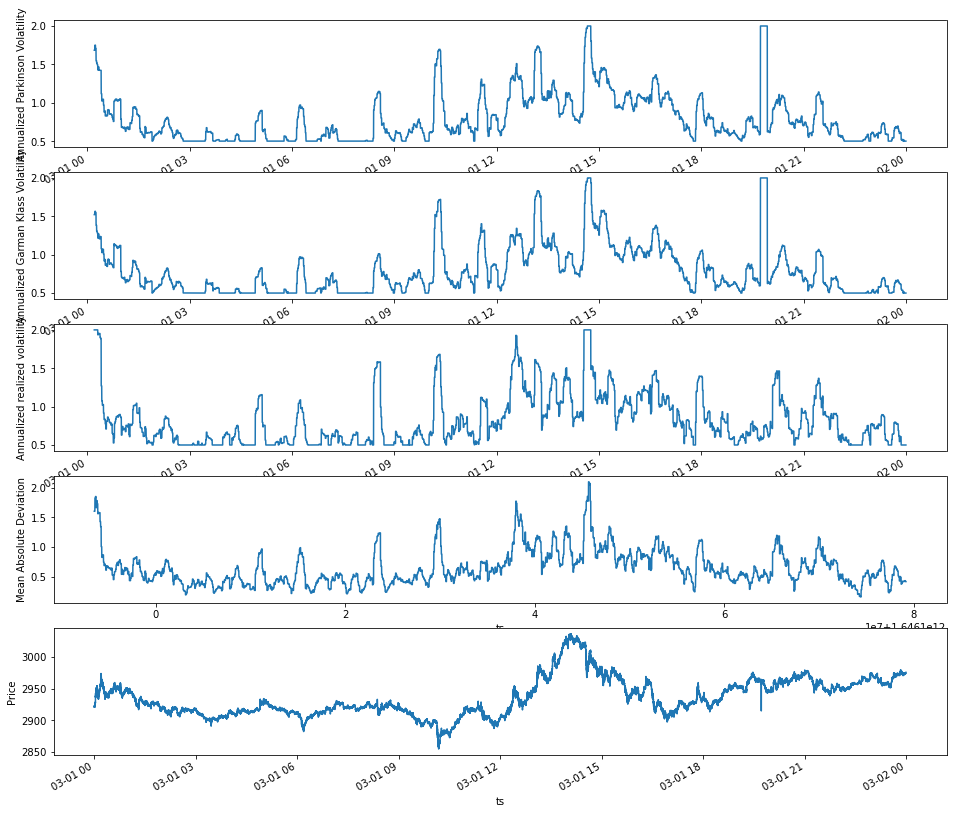

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(16,15))
axs[0].set_ylabel('Annualized Parkinson Volatility')
axs[1].set_ylabel('Annualized Garman Klass Volatility')
axs[2].set_ylabel('Annualized realized volatility')
axs[3].set_ylabel('Mean Absolute Deviation')
axs[4].set_ylabel('Price')
ser_vol_park.plot(ax=axs[0])
ser_vol_gk.plot(ax=axs[1])
ser_vol_rel.plot(ax=axs[2])
ser_mad.plot(ax=axs[3])
public_trades.price.plot(ax=axs[4])